In [121]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [123]:
import bnn.functions
import bnn.loss
import bnn.network

In [124]:
dims = [32]*3 + [128]*3 + [1024]*10 + [128]*3 + [32]*10
dims = [d*2 for d in dims]
TBNN = bnn.network.TernBinNetwork(*dims, bit_shift=2)

In [125]:
samples = 1

input = bnn.functions.binarise.apply(torch.randn(samples, dims[0]))
desired = bnn.functions.binarise.apply(torch.randn(samples, dims[-1]))

In [126]:
TBNN.zero_grad()
output = TBNN(input)
loss = bnn.loss.number_incorrect(output=output, label=desired)
loss.backward()

In [127]:
vars = [] 
grad_vars = []
grads = []

for layer in TBNN.layers.values():
    grads.append(layer.W.grad.detach())
    vars.append(layer.W.var().detach())
    grad_vars.append(layer.W.grad.var().detach())

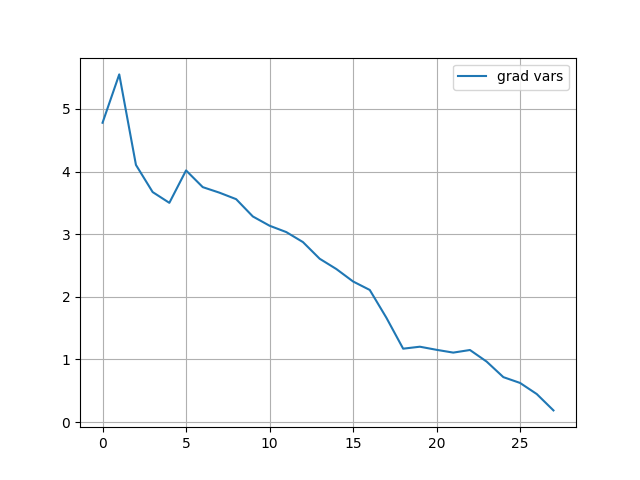

In [128]:
FIG_NAME = "vars over layers"
plt.close(FIG_NAME)

fig, ax = plt.subplots(1, 1, num=FIG_NAME)

#plt.plot(vars, label="vars")
ax.plot(grad_vars, label="grad vars")
ax.legend()
ax.grid()
plt.show()

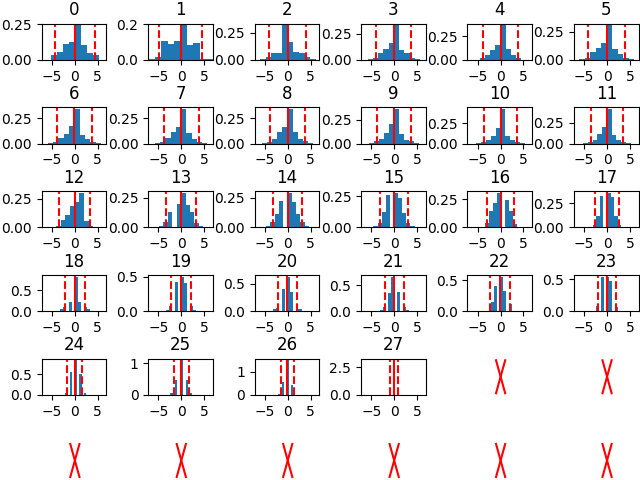

In [129]:
FIG_NAME = "distribution"
plt.close(FIG_NAME)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(grad_vars))).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
for i, (ax, W) in enumerate(zip(axs, grads + [None]*len(axs))):
    if W is None:
        ax.plot(np.linspace(-1, 1), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(1, -1), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        mean = W.mean().item()
        std = W.std().item()

        data = W.flatten()
        samples = 10000
        skip = int(np.ceil(len(data)/samples))
        ax.hist(data[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

In [130]:
for p in TBNN.parameters():
    print(p.grad.data)

tensor([[-2.,  0., -5.,  ..., -4.,  2., -1.],
        [-2.,  0., -5.,  ..., -4.,  2., -1.],
        [ 2., -0.,  5.,  ...,  4., -2.,  1.],
        ...,
        [-2.,  0., -5.,  ..., -4.,  2., -1.],
        [ 2., -0.,  5.,  ...,  4., -2.,  1.],
        [-2.,  0., -5.,  ..., -4.,  2., -1.]])
tensor([[-3.,  3., -0.,  ...,  1., -2.,  1.],
        [ 3., -3.,  0.,  ..., -1.,  2., -1.],
        [-3.,  3., -0.,  ...,  1., -2.,  1.],
        ...,
        [ 3., -3.,  0.,  ..., -1.,  2., -1.],
        [ 3., -3.,  0.,  ..., -1.,  2., -1.],
        [ 3., -3.,  0.,  ..., -1.,  2., -1.]])
tensor([[ 1., -2., -0.,  ...,  1., -1., -3.],
        [ 1., -2., -0.,  ...,  1., -1., -3.],
        [ 1., -2., -0.,  ...,  1., -1., -3.],
        ...,
        [-1.,  2.,  0.,  ..., -1.,  1.,  3.],
        [-1.,  2.,  0.,  ..., -1.,  1.,  3.],
        [-1.,  2.,  0.,  ..., -1.,  1.,  3.]])
tensor([[ 3.,  2.,  3.,  ...,  1.,  2., -1.],
        [-3., -2., -3.,  ..., -1., -2.,  1.],
        [-3., -2., -3.,  ..., -1., -2.